# 1. Import Library

# 資料準備

In [1]:

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model,Model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,GRU,Conv1D, MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D
from keras.utils import np_utils
from datetime import datetime,timedelta

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import adam
import tensorflow.keras as keras
import numpy as np
import requests
import pandas as pd

# import urllib.request
import os
import tarfile
np.random.seed(10)


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#os.chdir("../Project_19999/19999_2RNN")
#os.getcwd()

In [3]:
#from data_utils import cut_to_word,covert_sequences,get_word2vec_embeddings
#from data_utils import get_average_word2vec,produce_cbowfile,JiebaSegmentor,data_reduction,seperatedata
from data_utils import *
from data_utils import JiebaSegmentor

In [4]:
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,jieba_dict_path5],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

print(js)
# js = JiebaSegmentor(jieba_dict_path1, [jieba_dict_path2, jieba_dict_path3, jieba_dict_path4])

Building prefix dict from /project/at081-group3/Project_19999/19999_2RNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u5f4d4d2a4ebf6cacbf248ccc4ee696aa.cache
Loading model cost 0.512 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('BPM系統有問題', return_type='pandas')
# test_cut_raw_0
for x in test_cut_raw_0:
    print (x)

word


In [6]:
test_cut_raw_0 = js.pseg_lcut('BPM系統有問題，無法 使用')
test_cut_raw_0

,word,tag
0,BPM系統,ns
1,無法,n
2,,x
3,使用,n


In [7]:
test_cut_raw_0 = js.lcut('R&D系統有問題，無法使用')
test_cut_raw_0

,word
0,R&D
1,系統
2,無法使用


In [8]:
#先讀取所有文章建立字典，限制字典的數量為nb_words=2000

In [9]:
df = pd.read_csv('data/19999_question_category_a_v11_test.csv')#usecols=['description','category_a', 'category_a_target']

In [10]:
df.head(5)

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入 顯示訊息 無效的帳號或不存在 帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假 要補登先前的加班 但開啟camp後 出勤表單顯示的內容像測試的 沒有的時間也沒辦...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核BPM有問題 都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用CAMP進行表單簽核動作,4
4,"出差同仁無法登入camp, 委請同事詢問",CAMP,CAMP,CAMP,CAMP,資訊系統,出差同仁無法登入camp 委請同事詢問,4


In [11]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384 entries, 0 to 8383
Data columns (total 8 columns):
description          8384 non-null object
category_a           8384 non-null object
category_b           8384 non-null object
category_c           8384 non-null object
category_d           8384 non-null object
category             8384 non-null object
description_clean    8384 non-null object
category_target      8384 non-null int64
dtypes: int64(1), object(7)
memory usage: 524.1+ KB


In [12]:
# index to categories mapping
mapping = df.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [13]:
df.groupby(["category"]).size()

category
Outlook與郵件    1778
SAP           1443
其他            1470
網路            2314
資訊系統          1379
dtype: int64

In [14]:
#df['cut_words'] = df['description_add_category'].apply(lambda s: cut_to_word(s.strip(),js))
#df['cut_words'] = df['description_add_category'].apply(lambda s: cut_to_word(s.strip(),js))
#df['cut_words_clean'] = df['description_clean'].apply(lambda s: cut_to_word(s.strip(),js))
#df['cut_words_clean'] = df['description_clean'].apply(lambda s: cut_to_word(s.strip(),js))

#df['cut_words'] = df['description'].apply(lambda s: cut_to_word(s.strip(),js))
#df['cut_words'] = df['description'].apply(lambda s: cut_to_word(s.strip(),js))
df['cut_words'] = df['description_clean'].apply(lambda s: cut_to_word_pandas(s.strip(),js))
#df['cut_words'] = df['description_clean_add_category_abcd'].apply(lambda s: cut_to_word(s.strip(),js))


TODO: 拿掉時間,人名

In [15]:
# 資料打散
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,#18552 Outlook無法開啟，顯示載入設定檔。,網管,Outlook與郵件,Outlook,Outlook點不開,Outlook與郵件,Outlook無法開啟 顯示載入設定檔,0,"Outlook,無法開啟,顯示,載入,設定檔"
1,無法登入SAP 168,SAP-168(QCI),Basis,其它,無法logon SAP,SAP,無法登入SAP 168,1,"無法登入,SAP,168"
2,OutLook無法開啟#13159,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,OutLook無法開啟,0,"OutLook,無法開啟"
3,"user反應進SAP168帳號被lock住,Group ID：nb1sales01 ,煩請相...",SAP-168(QCI),Basis,帳號,帳號無法使用,SAP,進SAP168帳號被lock住 Group ID nb1sales01 相關同仁,1,"進,SAP,168,帳號,lock,住,Group,ID,nb1sales01,相關同仁"
4,有線網路無法連上Quanta網域(顯示為無法辨識的網路).,網管,網路,電腦網路不通,網路不通 (QRDC),網路,有線網路無法連上Quanta網域 顯示為無法辨識的網路,3,"有線網路,無法連上,Quanta,網域,顯示,無法,無法辨識,網路"


In [16]:

df[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,"詢問outlook 操作 (如何附檔,不讓別人下載)",網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,詢問outlook 操作 附檔 不讓下載,0,"詢問,outlook,操作,附檔,下載"
3041,"斷線, 北棟2f, PDC, 網孔編號PN01 B289",網管,網路,電腦網路不通,網路不通 (QRDC),網路,斷線 北棟2f PDC 網孔編號PN01 B289,3,"斷線,北棟,2f,PDC,網孔,編號,PN01,B289"
3042,我有負責阿里巴巴這個客戶的專案，他們自己有開發 釘釘 這套通訊軟體，可以溝通跟傳輸檔案 可...,網管,網路,無法連到某台Server,無法連到某些Server,網路,我有負責阿裡巴巴客戶的專案 有開發 釘釘 這套通訊軟體 可以溝通跟傳輸檔案 我在公司 大...,3,"負責,阿裡,巴巴,客戶,專案,開發,釘釘,這套,通訊,軟體,溝通,傳輸,檔案,公司,大部分,..."
3043,"在家使用時會顯示""憑證過期""",網管,VPN連線,SSLVPN問題,無法登入,網路,在家使用時會顯示 憑證過期,3,"家,使用,時會,顯示,憑證過期"
3044,User would like to set up trading partner in S...,SAP-168(QCI),SD,Master Data,其它,SAP,would like to set up trading partner in SAP bu...,1,"would,like,to,set,up,trading,partner,in,SAP,bu..."
3045,168 輸入ZBEI時 顯示Err 601 聯絡分機 13346,SAP-168(QCI),Basis,其它,Performance Issue,SAP,168 輸入ZBEI時 顯示Err 601,1,"168,輸入,ZBEI,時,顯示,Err,601"
3046,"using Vista Basic, but could not use SAP syste...",SAP-168(QCI),Basis,其它,安裝SAP,SAP,using Vista Basic but could not use SAP syste...,1,"using,Vista,Basic,but,could,not,use,SAP,system..."
3047,Pls help crate in QITS sys in “ platfrom-chips...,R&D資訊系統,測試相關服務,【QITS】研發議題追蹤系統,相關操作詢問,資訊系統,Pls help crate in QITS sys in “ platfrom cpset...,4,"Pls,help,crate,in,QITS,sys,in,platfrom,cpset,s..."
3048,"user美國出差,無法撥打電話與會議58000 聯絡方式 :1-5104359030",網管,商務用Skype,無法打電話,沒有聲音,其他,無法撥打與會議 方式,2,"無法,無法撥打,會議,方式"
3049,"使用外部網路outlook無法收信, webmail的網頁也無法連 一切回公司網路就正...",網管,Outlook與郵件,Outlook,信件有時無法下載,Outlook與郵件,使用外部網路outlook無法收信 webmail的網頁也無法連 回公司網路就正常 ...,0,"使用,外部,網路,outlook,無法收信,webmail,網頁,無法,無法回,公司網路,正..."


In [80]:
X = df['cut_words']
y = df['category_target']
#将数据划分为训练集和验证集
#注意要打乱数据，因为原始数据是分类排好序的
X_train, X_val, y_train, y_val =seperatedata(X,y)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 40)

In [81]:
X_train.head()

1158                               CCBU,今日,客人,信,退回
6284                          Outlook,收到,系統發出,通知,信
6719        NB檢測申請單,email,超連結,無法,無法指向,BPM,顯示,權限,受限
4672                                   無法登入,SAP,急單
2954    出現,OUTLOOK,認證,錯誤,已重,新,開機,登入,瀏覽器,IE,無法開啟,使用
Name: cut_words, dtype: object

In [82]:
# label 做 onehot
y_one_hot,num_classes = labelEncoding(y_train)


[1. 0. 0. 0. 0.]
num_classes = 5


In [83]:
df_val_y=y_val
df_val_x=X_val
df_val_x.head(10)

2865                              10.241,120.21,無法上傳,下載資料
8175                                     QCO,OUTLOOK,無法開啟
5933         需,申請,使用,Visio,Vistual,Studio,2014,程式語言,開發工,具
4857    Outlook,回人,mail,文字,格式,跑掉,確定,原因,重灌,Outlook,2010...
6859                                    網路不通,網,孔編,號為,D184
2031                         密碼,到期,後,無法,無法變更,密碼,成功,方式,轉,9
1056             接,網孔,B247,無法,無法連至,SEVER,進行,WINDOWNS,新,網孔
2858         Can,t,login,SAP,Error,message,Password,error
7216    已,MIS,提供,OPEN,VPN連線,步驟,操作,家裡,windows,10,連回,公司,...
4038                         查詢,ZM03,確認,時,出現錯誤,訊息,錯誤訊息,亂碼
Name: cut_words, dtype: object

In [84]:
# 標點符號過濾
WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
#只考虑数据集中前10000个最常见的单词
NUM_WORDS = 5001
# 向量長度
#100个单词后截断评论，这个参数非常影响准确度
MAX_LEN = 30

embedding_dim=256

#将整数列表转化成形状为（samples，maxlen）的二维整数张量
#x_train,train_word_index = covert_sequences(X_train,NUM_WORDS, MAX_LEN)
#x_val,train_word_index2 = covert_sequences(X_val,NUM_WORDS, MAX_LEN)
#x_train2=x_train
#x_train2,train_word_index = covert_sequences(x_train2.cut_words,NUM_WORDS, MAX_LEN)

In [85]:
token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)
    train_word_index = token_intent.word_index#找回单词索引
    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data,train_word_index

x_train,train_word_index = preprocessing(X_train, max_len=MAX_LEN)
x_val,train_word_index2 = preprocessing(X_val, max_len=MAX_LEN)

In [86]:
x_train

array([[   0,    0,    0, ...,   70,   79,  909],
       [   0,    0,    0, ..., 1850,  133,   79],
       [   0,    0,    0, ...,   11,   54, 3294],
       ...,
       [   0,    0,    0, ...,  387,    3,  124],
       [   0,    0,    0, ..., 1486,  525, 1139],
       [   0,    0,    0, ..., 1743,  106,   26]], dtype=int32)

In [87]:
x_train.shape, y.shape, x_val.shape

((6288, 30), (8384,), (2096, 30))

In [88]:
y_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# 建立模型

In [89]:
print(NUM_WORDS)
print(num_classes)
print(MAX_LEN)

5001
5
30



Attention

In [90]:
from keras.layers import Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
 
 
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
 
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
 
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
 
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
 
        a = K.exp(ait)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [91]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

RNN - LSTM

In [92]:
##BiDirectional RNN(CuDNNLSTM)
#https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-672-lb
#NUM_WORDS=embedding_matrix.shape[0]
#https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
#https://www.kaggle.com/suicaokhoailang/blending-with-linear-regression-0-688-lb
from keras.layers import core,BatchNormalization
#CuDNNLSTM比較厲害,65%
from keras.layers import CuDNNLSTM
def BidCuDNNLSTM(num_classes, vocab_size, sentence_max_len,embedding_dim):
    SEQ_LEN = 40  # magic number - length to truncate sequences of words
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        #weights=[embedding_matrix],#需要研究如何用, 結果會變差
                        input_length=sentence_max_len,trainable = False))
    model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
    #model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
    model.add(AttentionWithContext())
    #model.add(AttentionWithContext())
    #model.add(Dropout(0.5))
    #model.add(Flatten())
    #model.add(Dense(256,activation='tanh'))
    #model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [93]:
##BiDirectional RNN(LSTM) - one
def BidLSTM(num_classes, vocab_size, sentence_max_len,embedding_dim):
    SEQ_LEN=vocab_size
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(LSTM(128,implementation=2)))
    
    #x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,
    #                       recurrent_dropout=0.25))(x)
    model.add(Attention(SEQ_LEN))
    model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.5))
    #model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [94]:
##BiDirectional RNN(LSTM) - two
#https://www.kaggle.com/takuok/bidirectional-lstm-and-attention-lb-0-043
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout

#速度有點慢，不建議
def BidLstm(num_classes, vocab_size, sentence_max_len,embedding_dim):
    inp = Input(shape=(sentence_max_len, ))
    x = Embedding(vocab_size, embedding_dim, #weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Attention(sentence_max_len)(x)
    x = Dropout(0.5)(x)
    #x = Dense(256, activation="tanh")(x)
    #x = Dropout(0.5)(x)
    #x = Dense(num_classes, activation="sigmoid")(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    print(model.summary())
    return model

In [95]:

#https://www.kaggle.com/kakiac/deep-learning-4-text-classification-cnn-bi-lstm

In [96]:
#BiDirectional RNN(LSTM/GRU)
def model_lstm_du(num_classes, vocab_size, max_sequence_length, embedding_dim):
    #跑的比較慢，準確率也滿高的
    #https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
    #https://www.kaggle.com/sanket30/cudnnlstm-lstm-99-accuracy
    #https://www.kaggle.com/suicaokhoailang/10-fold-lstm-with-attention-0-991-lb
    #無法用predict_classes
    print(num_classes)
    print(max_sequence_length)
    print(embedding_dim)
    print(vocab_size)
    inp = Input(shape=(max_sequence_length,))
    x = Embedding(num_classes, embedding_dim#, weights=[embedding_matrix]
                 ,trainable=False)(inp)
    '''
    Here 64 is the size(dim) of the hidden state vector as well as the output vector. Keeping return_sequence we want the output for the entire sequence. So what is the dimension of output for this layer?
        64*70(maxlen)*2(bidirection concat)
    CuDNNLSTM is fast implementation of LSTM layer in Keras which only runs on GPU
    '''
    
    x = Bidirectional(LSTM(256,dropout=0.4,recurrent_dropout=0.4,activation='relu', return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    att = Attention(max_sequence_length)(x)
    conc = concatenate([att,avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.5)(conc)
    outp = Dense(num_classes, activation="softmax")(conc)
    model = Model(inputs=inp, outputs=outp)
    print(model.summary())
    return model



CNN - 1D

In [97]:
#https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm
#https://www.kaggle.com/eashish/bidirectional-gru-with-convolution
#https://stackoverflow.com/questions/53904688/using-keras-to-build-a-lstmconv2d-model
#效果也不錯,69%
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
def GRU(num_classes, vocab_size, max_sequence_length, embedding_dim):
    inp = Input(shape = (max_sequence_length,))
    x = Embedding(vocab_size, embedding_dim #, weights = [embedding_matrix]
                  , trainable = False)(inp)
    
    #組合1
    #x = SpatialDropout1D(0.7)(x)
    #x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    #x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)  
    
    #組合2
    #https://www.kaggle.com/eashish/bidirectional-gru-with-convolution
    #x = SpatialDropout1D(0.2)(x)
    #x = Bidirectional(CuDNNGRU(128,return_sequences=True))(x)
    
    #x = Dropout(0.5)(x)
    #x = Conv1D(64, kernel_size = 3, padding = "valid", activation='relu', kernel_initializer = "glorot_uniform")(x)
    
    #組合3
    #https://www.kaggle.com/taindow/simple-cudnngru-python-keras#Model-Architecture
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)   
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) 
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    att = Attention(39)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x) 
    conc = concatenate([att,avg_pool, max_pool])
    
    output = Dropout(0.7)(conc)
    output = Dense(units=16)(output)
    output = Activation('relu')(output)
    preds=Dense(num_classes, activation='softmax')(output)
    model = Model(inputs = inp, outputs = preds)
    print(model.summary())
    return model;

CNN

In [98]:
#CCN-78%
#https://www.kaggle.com/kakiac/deep-learning-4-text-classification-cnn-bi-lstm
#https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
from keras.layers.merge import concatenate, add
from keras.layers import CuDNNGRU
def build_CNN(num_classes, vocab_size, sentence_max_len,embedding_dim):
    inp = Input(shape=(sentence_max_len, ))
    embed_size = 240
    x = Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len)(inp)
    
    convs = []
    filter_sizes = [3,4,5] # in the loop, first apply 3 as size, then 4 then 5

    x = Dropout(0.5)(x)
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(x)
        #kernel is the filter
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)
    
    # activated if extra_convoluted is true at the def
    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=19, activation='relu')(x)
    pool = MaxPooling1D(pool_size=3)(conv)
    x = Dropout(0.5)(l_merge)  
    
    #x = Conv1D(filters=512,kernel_size=10,padding='same', activation='relu')(x)
    #x = GlobalMaxPooling1D()(x)
    #x = Bidirectional(CuDNNGRU(512, return_sequences=True))(x)
    #x = GlobalMaxPooling1D()(x)
    
    #x = Flatten()(x)
    
    
    
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    #x = Dense(6, activation="sigmoid")(x)
    outp = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=outp)
    print(model.summary())
    return model;
    

In [99]:
#75%
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len,embedding_dim):
    filters = 100
    kernel_size = 10
    hidden_dims = 250
    epochs = 20
    train_ratio = 0.9
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=256, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
                     
    # We add a vanilla hidden layer:
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [100]:
from keras.optimizers import Adam
model = build_1DCNN_model(num_classes, NUM_WORDS,MAX_LEN,embedding_dim)

model_name = '1999-Fine-Tune'
lr = 2e-5
optimizer = adam(lr=lr,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

optimizer2 = adam(lr = 1e-5, decay = 0.0)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 256)           1280256   
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 21, 100)           256100    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               51712     
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0     

# 訓練模型

In [101]:
###### model_name = 'intent_model'
model_path = 'saved_models/{}.h5'.format(model_name)
epochs =20
batch_size = 20
train_ratio = 0.2

class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))
        
#model_path = './saved_models/DensetNet_0524001.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001, cooldown=1)

earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

my_calback_object = MyCallback() # create an object of the MyCallback class

model_history = model.fit(x=x_train, y=y_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio
                          #callbacks = [ checkpoint,earlystop]
                         )

Train on 1257 samples, validate on 5031 samples
Epoch 1/20
1257/1257 [==============================] - 1s 971us/step - loss: 1.6063 - acc: 0.2387 - val_loss: 1.5903 - val_acc: 0.2904
Epoch 2/20
1257/1257 [==============================] - 1s 426us/step - loss: 1.5831 - acc: 0.2506 - val_loss: 1.5595 - val_acc: 0.2914
Epoch 3/20
1257/1257 [==============================] - 1s 419us/step - loss: 1.4839 - acc: 0.3238 - val_loss: 1.2053 - val_acc: 0.4433
Epoch 4/20
1257/1257 [==============================] - 1s 423us/step - loss: 0.9404 - acc: 0.6142 - val_loss: 0.8209 - val_acc: 0.6943
Epoch 5/20
1257/1257 [==============================] - 1s 418us/step - loss: 0.4987 - acc: 0.8130 - val_loss: 0.7988 - val_acc: 0.7339
Epoch 6/20
1257/1257 [==============================] - 1s 427us/step - loss: 0.2906 - acc: 0.8926 - val_loss: 0.9072 - val_acc: 0.7507
Epoch 7/20
1257/1257 [==============================] - 1s 424us/step - loss: 0.1601 - acc: 0.9467 - val_loss: 1.0233 - val_acc: 0.7410


In [102]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


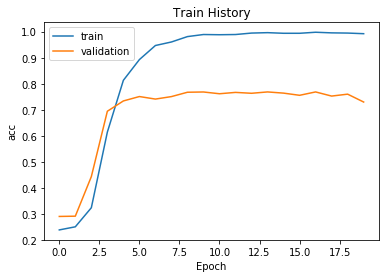

In [103]:
show_train_history(model_history,'acc','val_acc')

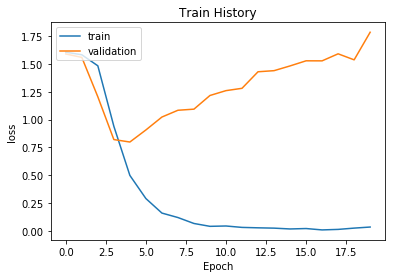

In [104]:
show_train_history(model_history,'loss','val_loss')

In [105]:
# model.save(model_path)
x_val

array([[   0,    0,    0, ...,  425,  579, 2534],
       [   0,    0,    0, ...,  249,    2,   22],
       [   0,    0,    0, ..., 1337, 1895, 4739],
       ...,
       [   0,    0,    0, ...,    1, 1017, 2433],
       [   0,    0,    0, ...,   43,  313,  604],
       [   0,    0,    0, ...,   86,    5,    7]], dtype=int32)

In [106]:
y_predict_name, y_predict, predict_arr,y_predict_probability = predict_class(model,x_val,64,mapping)

2096/2096 [==============================] - 0s 84us/step


In [107]:
#y_predict_probability2=y_predict_probability.astype(float)
#y_predict_probability3 = pd.Series(['{0:.2f}%'.format(val * 100) for val in y_predict_probability2])

In [108]:
#model.predict_classes(x_val)

In [109]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [110]:
def to_cat_name(x): 
        return mapping[x]
answer_name=to_cat_name(y_val)

In [111]:
predict_df = pd.DataFrame({'1_sentence':X_val,'2_sentence':'',
              '3_y_predict':y_predict,
              '4_y_predict_name':y_predict_name,
              '5_answer':y_val,
              '6_answer':answer_name,
              '7_y_predict_probability':list(predict_arr),
              })
#print( format(y_predict_probability, '.3%'))
predict_df[:10]

,1_sentence,2_sentence,3_y_predict,4_y_predict_name,5_answer,6_answer,7_y_predict_probability
2865,"10.241,120.21,無法上傳,下載資料",,2,其他,3,網路,"[Outlook與郵件:0.00021903894, SAP:0.00051423104, ..."
8175,"QCO,OUTLOOK,無法開啟",,0,Outlook與郵件,0,Outlook與郵件,"[Outlook與郵件:0.99999535, SAP:0.0000000017619948..."
5933,"需,申請,使用,Visio,Vistual,Studio,2014,程式語言,開發工,具",,2,其他,2,其他,"[Outlook與郵件:0.00000003747275, SAP:0.0000000012..."
4857,"Outlook,回人,mail,文字,格式,跑掉,確定,原因,重灌,Outlook,2010...",,0,Outlook與郵件,0,Outlook與郵件,"[Outlook與郵件:0.9999839, SAP:0.00000000005023991..."
6859,"網路不通,網,孔編,號為,D184",,3,網路,3,網路,"[Outlook與郵件:0.00000018616905, SAP:0.0000048444..."
2031,"密碼,到期,後,無法,無法變更,密碼,成功,方式,轉,9",,2,其他,2,其他,"[Outlook與郵件:0.00000010189481, SAP:0.0000001705..."
1056,"接,網孔,B247,無法,無法連至,SEVER,進行,WINDOWNS,新,網孔",,3,網路,3,網路,"[Outlook與郵件:0.00000000006425293, SAP:0.0000000..."
2858,"Can,t,login,SAP,Error,message,Password,error",,1,SAP,1,SAP,"[Outlook與郵件:0.000000000000000000000028299098, ..."
7216,"已,MIS,提供,OPEN,VPN連線,步驟,操作,家裡,windows,10,連回,公司,...",,3,網路,3,網路,"[Outlook與郵件:0.00000003468055, SAP:0.0000016301..."
4038,"查詢,ZM03,確認,時,出現錯誤,訊息,錯誤訊息,亂碼",,1,SAP,1,SAP,"[Outlook與郵件:0.0015488357, SAP:0.92404014, 其他:0..."


In [112]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['3_y_predict'] != predict_df['5_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.7290076335877862 !!!!!!!!


In [54]:
differ_ans=predict_df[predict_df['3_y_predict'] != predict_df['5_answer']]
differ_ans

,1_sentence,2_sentence,3_y_predict,4_y_predict_name,5_answer,6_answer,7_y_predict_probability
2865,"10.241,120.21,無法上傳,下載資料",,1,SAP,3,網路,"[Outlook與郵件:0.004221432, SAP:0.7535786, 其他:0.2..."
7216,"已,MIS,提供,OPEN,VPN連線,步驟,操作,家裡,windows,10,連回,公司,...",,2,其他,3,網路,"[Outlook與郵件:0.000000616987, SAP:0.000000230768..."
8382,"人,國外,更改,密碼,後,無法登入,請,同事,聯繫",,1,SAP,2,其他,"[Outlook與郵件:0.00000044623675, SAP:0.99998987, ..."
3915,"更換,兩,個月,LYNC,顯示,舊,PS,OUTLOOK,正確",,0,Outlook與郵件,2,其他,"[Outlook與郵件:0.79415625, SAP:0.000057324774, 其他..."
7837,"無法更新,windows",,1,SAP,2,其他,"[Outlook與郵件:0.040786393, SAP:0.50953126, 其他:0...."
3392,"請,加入,Carol,C,紀彥,合,使用權,限",,0,Outlook與郵件,4,資訊系統,"[Outlook與郵件:0.5618699, SAP:0.10936918, 其他:0.13..."
5826,"NB,無法使用,WLAN",,2,其他,3,網路,"[Outlook與郵件:0.025334941, SAP:0.058305487, 其他:0..."
5810,"can,t,log,on",,1,SAP,3,網路,"[Outlook與郵件:0.0026213322, SAP:0.99616563, 其他:0..."
1195,"電腦開機,時,出現,保密,防,盜版,認,視窗,知,有無,登入",,4,資訊系統,2,其他,"[Outlook與郵件:0.042535365, SAP:0.0076047196, 其他:..."
3334,"IE,時常,重新,啟動,狀態",,0,Outlook與郵件,2,其他,"[Outlook與郵件:0.95457214, SAP:0.022398552, 其他:0...."


In [ ]:
pd.DataFrame(differ_ans).to_csv('differ_ans_ab_Network2.csv')

In [ ]:
# confusion matrix
def to_cat_name(x): 
        return mapping[x]
pd.crosstab(np.array(y_predict_name), to_cat_name(np.array(y_val)),
            rownames=['3_y_predict'], colnames=['answer'])